## Overview

1. Query the GRSS VEDA STAC API to discover available dates and temporal frequency for the Wetland Methane Emissions collection.
2. Generate map tiles using the raster API endpoint.
3. Compare methane emissions across different time periods using side-by-side visualization with `folium.plugins.DualMap`.
4. Compute zonal statistics for a specified region of interest.

## Background

Wetland ecosystems represent the dominant natural source of atmospheric methane (CH₄), accounting for approximately one-third of total global emissions from both natural and human-caused sources. The production of methane in wetlands occurs through microbial decomposition of organic matter in waterlogged, oxygen-depleted soils.

The LPJ-EOSIM (Lund-Potsdam-Jena Earth Observation SIMulator) model provides global estimates of wetland methane emissions at 0.5° × 0.5° spatial resolution. The model simulates wetland extent and incorporates key environmental parameters including soil moisture, temperature, and carbon content to estimate CH₄ flux rates.

This dataset reveals concentrated methane sources in tropical regions and high-latitude ecosystems. The model outputs are used with NASA's GEOS atmospheric model to understand how wetland emissions influence global methane concentrations.

## Required Libraries

Install dependencies if running outside the hub environment:

```
%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet
```

## Connect to the STAC API

Import required libraries and configure the API endpoints to access the GRSS VEDA STAC catalog.

In [1]:
import requests
import folium
import folium.plugins
from folium import Map, TileLayer
from pystac_client import Client
import branca
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
# Configure API endpoints for the GRSS VEDA platform
STAC_API_URL = "https://api.dev.veda.grss.cloud/stac"
RASTER_API_URL = "https://api.dev.veda.grss.cloud/raster"

# Collection identifier for wetland methane emissions
collection_name = "LPJ_EOSIM_L2_MCH4E.001"

# Asset containing the ensemble mean CH4 emissions data
asset_name = "ensemble-mean-ch4-wetlands-emissions"

In [10]:
# Retrieve collection metadata
collection = requests.get(f"{STAC_API_URL}/collections/{collection_name}").json()
collection

{'id': 'LPJ_EOSIM_L2_MCH4E.001',
 'type': 'Collection',
 'links': [{'rel': 'items',
   'type': 'application/geo+json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/LPJ_EOSIM_L2_MCH4E.001/items'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/'},
  {'rel': 'self',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/LPJ_EOSIM_L2_MCH4E.001'},
  {'rel': 'http://www.opengis.net/def/rel/ogc/1.0/queryables',
   'type': 'application/schema+json',
   'title': 'Queryables',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/LPJ_EOSIM_L2_MCH4E.001/queryables'}],
 'title': '(Monthly) Wetland Methane Emissions, LPJ-EOSIM Model v2',
 'assets': {},
 'extent': {'spatial': {'bbox': [[-180, -90, 180, 90]]},
  'temporal': {'interval': [['2017-06-01T00:00:00+00:00',
     '2023-12-31T00:0

The collection metadata shows temporal coverage from 1990 to present with daily observations, as indicated by `dashboard:time_density`.

In [14]:
def count_collection_items(collection_id):
    """Count total items in a STAC collection using pagination."""
    count = 0
    items_url = f"{STAC_API_URL}/collections/{collection_id}/items"

    while True:
        response = requests.get(items_url)
        if not response.ok:
            print("Error retrieving items")
            break

        stac = response.json()
        count += int(stac.get("numberReturned", 0))

        next_link = [link for link in stac["links"] if link["rel"] == "next"]
        if not next_link:
            break
        items_url = next_link[0]["href"]

    return count

In [15]:
# Fetch available items from the collection
total_count = count_collection_items(collection_name)
items = requests.get(f"{STAC_API_URL}/collections/{collection_name}/items?limit=600").json()["features"]
print(f"Retrieved {len(items)} items from collection")

Retrieved 79 items from collection


In [16]:
# Inspect the structure of an individual item
items[0]

{'id': 'LPJ_EOSIM_L2_MCH4E.001-202312',
 'bbox': [-180.0, -90.0, 180.0, 90.0],
 'type': 'Feature',
 'links': [{'rel': 'collection',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/LPJ_EOSIM_L2_MCH4E.001'},
  {'rel': 'parent',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/LPJ_EOSIM_L2_MCH4E.001'},
  {'rel': 'root',
   'type': 'application/json',
   'href': 'https://api.dev.veda.grss.cloud/stac/'},
  {'rel': 'self',
   'type': 'application/geo+json',
   'href': 'https://api.dev.veda.grss.cloud/stac/collections/LPJ_EOSIM_L2_MCH4E.001/items/LPJ_EOSIM_L2_MCH4E.001-202312'},
  {'title': 'Map of Item',
   'href': 'https://api.dev.veda.grss.cloud/raster/collections/LPJ_EOSIM_L2_MCH4E.001/items/LPJ_EOSIM_L2_MCH4E.001-202312/WebMercatorQuad/map?assets=ensemble-mean-ch4-wetlands-emissions&rescale=0%2C3e-09&colormap_name=magma',
   'rel': 'preview',
   'type': 'text/html'}],
 'assets': {'era5-ch4-wetlands-emi

Set rescale values for visualization:

In [18]:
rescale_values = {'max': 0.0003, 'min': 0.0}

## Visualize Methane Emissions Over Time

Generate map tiles using the Raster API to compare emissions across different dates.

In [20]:
# Index items by date for easy lookup
items_by_date = {item["properties"]["start_datetime"][:10]: item for item in items}

In [24]:
items_by_date['2023-07-01']['id']

'LPJ_EOSIM_L2_MCH4E.001-202307'

In [26]:
color_map = "magma"

# Fetch tiles for summer observation (July)
summer_date = '2023-07-01'
summer_tile = requests.get(
    f"{RASTER_API_URL}/collections/{collection_name}/items/{items_by_date[summer_date]['id']}/WebMercatorQuad/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

summer_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://api.dev.veda.grss.cloud/raster/collections/LPJ_EOSIM_L2_MCH4E.001/items/LPJ_EOSIM_L2_MCH4E.001-202307/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.0003'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [29]:
# Fetch tiles for winter observation (January)
winter_date = '2023-01-01'
winter_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items_by_date[winter_date]['collection']}/items/{items_by_date[winter_date]['id']}/WebMercatorQuad/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

winter_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://api.dev.veda.grss.cloud/raster/collections/LPJ_EOSIM_L2_MCH4E.001/items/LPJ_EOSIM_L2_MCH4E.001-202301/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.0003'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Side-by-Side Comparison: Summer vs Winter Emissions

In [31]:
# Compare summer and winter emissions over Southeast Asia
map_ = folium.plugins.DualMap(location=(15, 100), zoom_start=4)

summer_layer = TileLayer(
    tiles=summer_tile["tiles"][0],
    attr="GRSS VEDA",
    opacity=0.6,
)
summer_layer.add_to(map_.m1)

winter_layer = TileLayer(
    tiles=winter_tile["tiles"][0],
    attr="GRSS VEDA",
    opacity=0.6,
)
winter_layer.add_to(map_.m2)

map_

## Zonal Statistics Analysis

Define a region of interest to compute statistics over time. Here we analyze emissions across the Amazon basin.

In [32]:
# Define Amazon basin region
amazon_aoi = {
    "type": "Feature",
    "properties": {},
    "geometry": {
        "coordinates": [
            [
                [-70, -10],
                [-70, 5],
                [-50, 5],
                [-50, -10],
                [-70, -10]
            ]
        ],
        "type": "Polygon",
    },
}

In [33]:
# Display the AOI on a map
aoi_map = Map(
    tiles="OpenStreetMap",
    location=[-2, -60],
    zoom_start=4,
)

folium.GeoJson(amazon_aoi, name="Amazon Basin").add_to(aoi_map)
aoi_map

In [34]:
# Refresh items list
items = requests.get(
    f"{STAC_API_URL}/collections/{collection_name}/items?limit=600"
).json()["features"]
print(f"Processing {len(items)} items")

Processing 79 items


In [37]:
def compute_statistics(item, geojson):
    """Calculate zonal statistics for a single item over the given AOI."""
    result = requests.post(
        f"{RASTER_API_URL}/cog/statistics",
        params={"url": item["assets"][asset_name]["href"]},
        json=geojson,
    ).json()

    return {
        **result["properties"],
        "datetime": item["properties"]["start_datetime"],
    }

In [38]:
%%time
# Compute statistics for all available items
stats = [compute_statistics(item, amazon_aoi) for item in items]

CPU times: user 1.16 s, sys: 164 ms, total: 1.32 s
Wall time: 1min 5s


In [39]:
# Preview statistics from first item
stats[0]

{'statistics': {'b1': {'min': 0.0,
   'max': 1.9596972933300094e-09,
   'mean': 1.3262628495436246e-10,
   'count': 1184.0,
   'sum': 1.5702951827734069e-07,
   'std': 2.2244537361546118e-10,
   'median': 4.504550898953852e-11,
   'majority': 0.0,
   'minority': 3.515131938661571e-16,
   'unique': 1175.0,
   'histogram': [[946, 127, 48, 31, 16, 7, 4, 3, 0, 2],
    [0.0,
     1.9596972655744338e-10,
     3.9193945311488676e-10,
     5.879091657945423e-10,
     7.838789062297735e-10,
     9.798486466650047e-10,
     1.1758183315890847e-09,
     1.371788127535467e-09,
     1.567757812459547e-09,
     1.763727497383627e-09,
     1.9596972933300094e-09]],
   'valid_percent': 98.67,
   'masked_pixels': 16.0,
   'valid_pixels': 1184.0,
   'percentile_2': 3.5622706499004175e-13,
   'percentile_98': 8.656201866408253e-10}},
 'datetime': '2023-12-01T00:00:00Z'}

In [40]:
def format_stats_dataframe(stats_json):
    """Convert statistics JSON to a pandas DataFrame."""
    df = pd.json_normalize(stats_json)
    df.columns = [col.replace("statistics.b1.", "") for col in df.columns]
    df["date"] = pd.to_datetime(df["datetime"])
    return df

df = format_stats_dataframe(stats)
df.head()

,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2023-12-01T00:00:00Z,0.0,1.959697e-09,1.326263e-10,1184.0,1.570295e-07,2.224454e-10,4.504551e-11,0.0,3.515132e-16,1175.0,"[[946, 127, 48, 31, 16, 7, 4, 3, 0, 2], [0.0, ...",98.67,16.0,1184.0,3.562271e-13,8.656202e-10,2023-12-01 00:00:00+00:00
1,2023-11-01T00:00:00Z,0.0,1.458412e-09,7.439366e-11,1184.0,8.808209e-08,1.382741e-10,2.440544e-11,0.0,4.514389e-16,1175.0,"[[1022, 88, 41, 14, 7, 7, 2, 1, 1, 1], [0.0, 1...",98.67,16.0,1184.0,1.529063e-13,4.990412e-10,2023-11-01 00:00:00+00:00
2,2023-10-01T00:00:00Z,0.0,1.405805e-09,6.002457e-11,1184.0,7.106909e-08,1.099642e-10,1.825424e-11,0.0,6.518826e-16,1175.0,"[[1038, 88, 41, 7, 5, 3, 1, 0, 0, 1], [0.0, 1....",98.67,16.0,1184.0,1.417882e-13,3.901165e-10,2023-10-01 00:00:00+00:00
3,2023-09-01T00:00:00Z,0.0,1.231651e-09,4.619366e-11,1184.0,5.469329e-08,9.049517e-11,1.315866e-11,0.0,7.323344e-16,1175.0,"[[1059, 89, 20, 9, 2, 1, 2, 1, 0, 1], [0.0, 1....",98.67,16.0,1184.0,1.210498e-13,2.977404e-10,2023-09-01 00:00:00+00:00
4,2023-08-01T00:00:00Z,0.0,1.872944e-09,8.588581e-11,1184.0,1.016888e-07,1.791557e-10,1.520345e-11,0.0,2.753062e-15,1175.0,"[[1019, 99, 31, 15, 5, 10, 2, 2, 0, 1], [0.0, ...",98.67,16.0,1184.0,1.849912e-13,6.827569e-10,2023-08-01 00:00:00+00:00


## Time Series Visualization

Plot the temporal evolution of methane emissions over the Amazon basin.

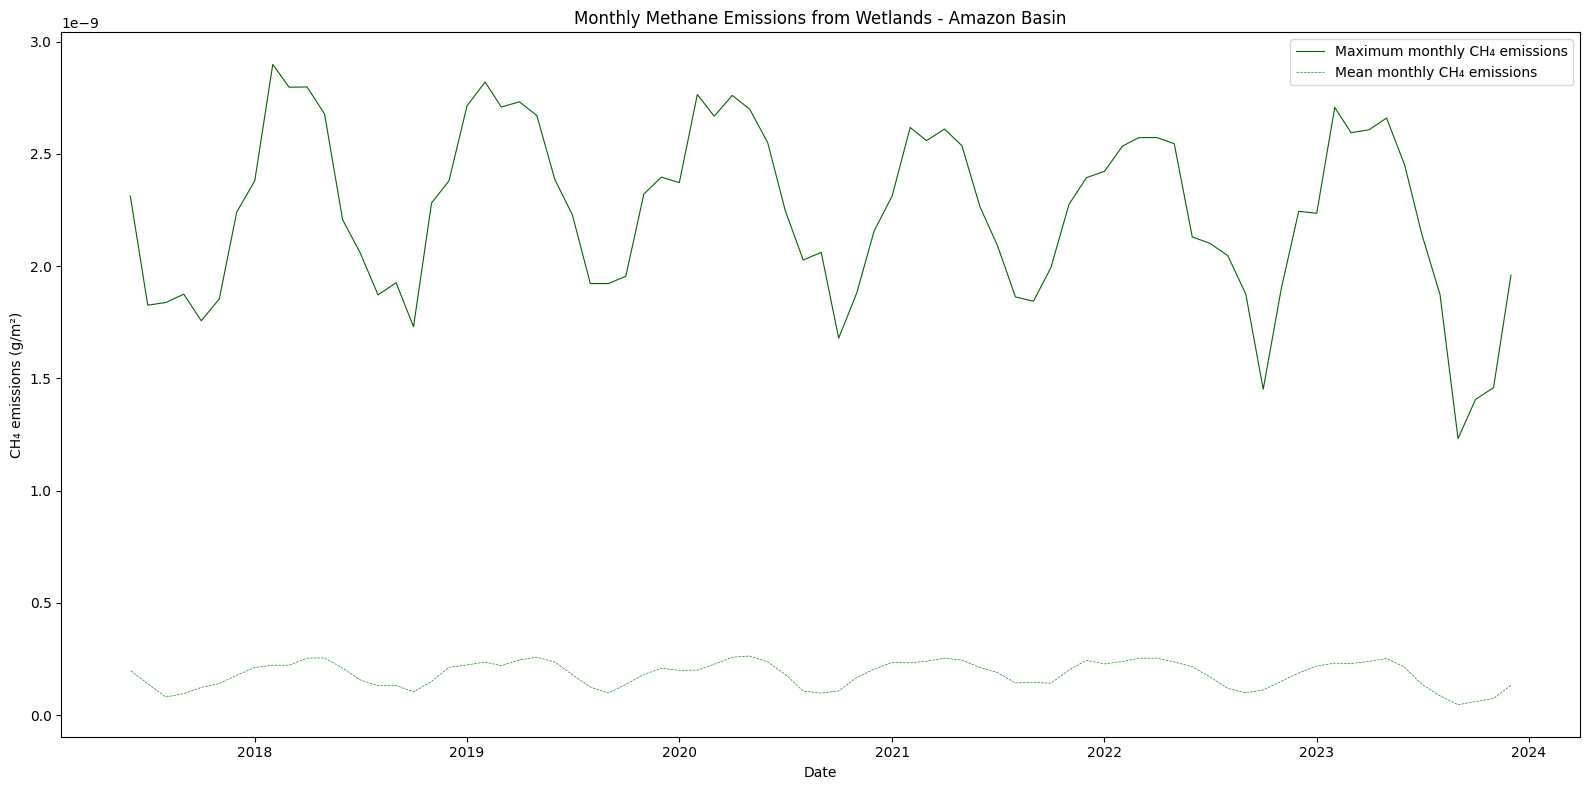

In [42]:
fig = plt.figure(figsize=(16, 8))

plt.plot(
    df["date"],
    df["max"],
    color="darkgreen",
    linestyle="-",
    linewidth=0.8,
    label="Maximum monthly CH₄ emissions",
)

plt.plot(
    df["date"],
    df["mean"],
    color="forestgreen",
    linestyle="--",
    linewidth=0.5,
    label="Mean monthly CH₄ emissions",
)

plt.legend()
plt.xlabel("Date")
plt.ylabel("CH₄ emissions (g/m²)")
plt.title("Monthly Methane Emissions from Wetlands - Amazon Basin")
plt.tight_layout()

## Regional Snapshot

Visualize a specific observation over the Amazon region.

In [44]:
# Select a specific observation
print(f"Selected date: {items[10]['properties']['start_datetime']}")

Selected date: 2023-02-01T00:00:00Z


In [47]:
selected_tile = requests.get(
    f"{RASTER_API_URL}/collections/{items[10]['collection']}/items/{items[10]['id']}/WebMercatorQuad/tilejson.json?&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

selected_tile

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://api.dev.veda.grss.cloud/raster/collections/LPJ_EOSIM_L2_MCH4E.001/items/LPJ_EOSIM_L2_MCH4E.001-202302/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ensemble-mean-ch4-wetlands-emissions&color_formula=gamma+r+1.05&colormap_name=magma&rescale=0.0%2C0.0003'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [48]:
# Create map centered on Amazon region
regional_map = Map(
    tiles="OpenStreetMap",
    location=[-5, -60],
    zoom_start=5,
)

tile_layer = TileLayer(
    tiles=selected_tile["tiles"][0],
    attr="GRSS VEDA",
    opacity=0.6
)
tile_layer.add_to(regional_map)

regional_map

## Summary

This notebook demonstrated how to:
1. Connect to the GRSS VEDA STAC API and query collection metadata
2. Retrieve and count available data granules
3. Generate and compare map visualizations across different time periods
4. Define areas of interest and compute zonal statistics
5. Create time series plots to analyze temporal patterns in methane emissions